# Imports and Data Preparation

In [128]:
import os
import pandas as pd

import statistics
import networkx as nx
import matplotlib.pyplot as plt

In [129]:
file_names = [x for x in os.listdir("../data") if not x.startswith("flight")]
file_names

['19DEC2023_AMS.csv',
 '19DEC2023_HKG.csv',
 '19DEC2023_LHR.csv',
 '20DEC2023_HKG.csv',
 '21DEC2023_AMS.csv',
 '21DEC2023_HKG.csv',
 '22DEC2023_AMS.csv',
 '22DEC2023_HKG.csv']

In [130]:
df = pd.DataFrame()
for file in file_names:
    tmp = pd.read_csv(f"../data/{file}")
    print(file)
    # parse dates
    try:
        day_offset = int(file[:2]) - 1
        tmp.time_sch = pd.to_datetime(tmp.time_sch) + pd.offsets.DateOffset(years=-1, months=11, days=day_offset)
        tmp.time_act = pd.to_datetime(tmp.time_act) + pd.offsets.DateOffset(years=-1, months=11, days=day_offset)
        tmp['source'] = file # just to check

        df = pd.concat([df, tmp], ignore_index=True)

    except Exception as e:
        print(e)
        continue

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

19DEC2023_AMS.csv
19DEC2023_HKG.csv
Unknown datetime string format, unable to parse: Dep 00:12, at position 0
19DEC2023_LHR.csv
20DEC2023_HKG.csv
Unknown datetime string format, unable to parse: Dep 00:06, at position 0
21DEC2023_AMS.csv
21DEC2023_HKG.csv
Unknown datetime string format, unable to parse: Dep 00:09, at position 0
22DEC2023_AMS.csv
22DEC2023_HKG.csv
Unknown datetime string format, unable to parse: At gate 00:00, at position 0


C:\Users\Javier Alfaro\AppData\Local\Temp\ipykernel_24924\3683686261.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tmp.time_sch = pd.to_datetime(tmp.time_sch) + pd.offsets.DateOffset(years=-1, months=11, days=day_offset)
C:\Users\Javier Alfaro\AppData\Local\Temp\ipykernel_24924\3683686261.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tmp.time_act = pd.to_datetime(tmp.time_act) + pd.offsets.DateOffset(years=-1, months=11, days=day_offset)
C:\Users\Javier Alfaro\AppData\Local\Temp\ipykernel_24924\3683686261.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tmp.t

In [131]:
df

,time_sch,time_act,code,dest,stat,orig,source,url
0,2023-12-19 06:00:00,2023-12-19 06:00:00,HV 5315 Transavia,Larnaca (LCA),DEPARTED,Amsterdam,19DEC2023_AMS.csv,NaN
1,2023-12-19 06:30:00,2023-12-19 06:30:00,HV 6411 Transavia,Naples (NAP),DEPARTED,Amsterdam,19DEC2023_AMS.csv,NaN
2,2023-12-19 06:30:00,2023-12-19 07:04:00,HV 6901 Transavia,Dubai International (DXB),DEPARTED,Amsterdam,19DEC2023_AMS.csv,NaN
3,2023-12-19 06:40:00,2023-12-19 06:55:00,HV 5951 Transavia,Lisbon (LIS),DEPARTED,Amsterdam,19DEC2023_AMS.csv,NaN
4,2023-12-19 06:40:00,2023-12-19 06:40:00,HV 6331 Transavia,Valencia (VLC),DEPARTED,Amsterdam,19DEC2023_AMS.csv,NaN
...,...,...,...,...,...,...,...,...
4898,2023-12-22 00:35:00,2023-12-22 01:56:00,HV 5686 Transavia,Amsterdam,BAGGAGE HANDLED,Arrecife (ACE),22DEC2023_AMS.csv,NaN
4899,2023-12-22 00:35:00,2023-12-22 00:56:00,HV 6674 Transavia,Amsterdam,BAGGAGE HANDLED,Tenerife (TFS),22DEC2023_AMS.csv,NaN
4900,2023-12-22 00:45:00,2023-12-22 00:45:00,HV 5674 Transavia,Amsterdam,BAGGAGE HANDLED,Ibiza (IBZ),22DEC2023_AMS.csv,NaN
4901,2023-12-22 00:50:00,2023-12-22 01:07:00,HV 5628 Transavia,Amsterdam,BAGGAGE HANDLED,Palma (PMI),22DEC2023_AMS.csv,NaN


In [132]:
df.source.value_counts()

source
22DEC2023_AMS.csv    1281
19DEC2023_LHR.csv    1275
21DEC2023_AMS.csv    1200
19DEC2023_AMS.csv    1147
Name: count, dtype: int64

In [133]:
df['delay'] = (df.time_act - df.time_sch).dt.seconds / 60 # in minutes

In [134]:
df.delay.describe()

count    4887.000000
mean      148.512994
std       372.510120
min         0.000000
25%         0.000000
50%        20.000000
75%        60.000000
max      1439.000000
Name: delay, dtype: float64

<Axes: >

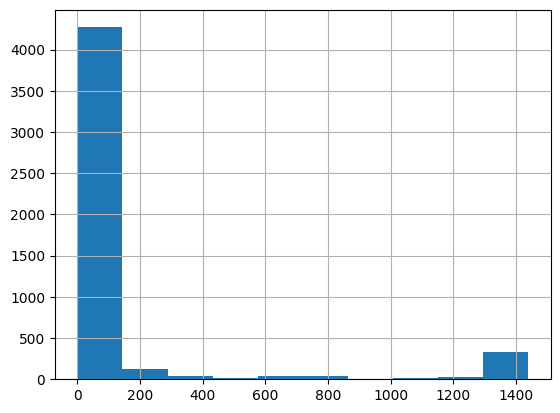

In [135]:
df.delay.hist()

# Delay Minimization

In [136]:
df.head()

,time_sch,time_act,code,dest,stat,orig,source,url,delay
0,2023-12-19 06:00:00,2023-12-19 06:00:00,HV 5315 Transavia,Larnaca (LCA),DEPARTED,Amsterdam,19DEC2023_AMS.csv,NaN,0.0
1,2023-12-19 06:30:00,2023-12-19 06:30:00,HV 6411 Transavia,Naples (NAP),DEPARTED,Amsterdam,19DEC2023_AMS.csv,NaN,0.0
2,2023-12-19 06:30:00,2023-12-19 07:04:00,HV 6901 Transavia,Dubai International (DXB),DEPARTED,Amsterdam,19DEC2023_AMS.csv,NaN,34.0
3,2023-12-19 06:40:00,2023-12-19 06:55:00,HV 5951 Transavia,Lisbon (LIS),DEPARTED,Amsterdam,19DEC2023_AMS.csv,NaN,15.0
4,2023-12-19 06:40:00,2023-12-19 06:40:00,HV 6331 Transavia,Valencia (VLC),DEPARTED,Amsterdam,19DEC2023_AMS.csv,NaN,0.0


In [137]:
G = nx.DiGraph()

for index, row in df.iterrows():
    G.add_edge(
        row['orig'], 
        row['dest'], 
        departure_time=row['time_sch'],
        delay=row['delay'],
    )


num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges

(389, 744)

In [148]:
# custom function to optimize the network
def optimize_flight_route(graph):
    # finding most profitable paths. The weight can be any variable in the dataset!
    path_weights = nx.all_pairs_bellman_ford_path_length(graph, weight='delay')
    
    final_sorted_paths = {}
    for source, weights in path_weights:
        # filter out the self-path (going back to the origin) and paths with non-positive weights
        filtered_weights = {node: weight for node, weight in weights.items() if node != source and weight > 0}
        
        # if not filtered_weights: final_sorted_paths[source] = []
        if not filtered_weights: continue # skip empty paths
            
        # sort the paths as desired (since Djikstra's finds the min path)
        sorted_paths = sorted(filtered_weights.items(), key=lambda x: x[1], reverse=False)
        final_sorted_paths[source] = sorted_paths
        
    return final_sorted_paths

# run the optimization algorithm
optimized_paths = optimize_flight_route(G)

In [149]:
len(optimized_paths.keys()) # origins!

374

In [150]:
df.orig.value_counts()

orig
Amsterdam                1823
London                    637
London Heathrow (LHR)      53
Barcelona (BCN)            42
London City (LCY)          40
                         ... 
Chennai                     1
Accra                       1
Isle of Man                 1
Bengaluru                   1
Heraklion (HER)             1
Name: count, Length: 377, dtype: int64

In [157]:
optimized_paths.get("London")[:20]

[('Singapore', 1.0),
 ('Johannesburg', 5.0),
 ('Dublin', 6.0),
 ('Shannon', 8.0),
 ('Bogota', 8.0),
 ('TFU', 9.0),
 ('Athens', 11.0),
 ('Bahrain', 12.0),
 ('Shanghai', 12.0),
 ('Cairo', 13.0),
 ('Bridgetown', 13.0),
 ('PKX', 13.0),
 ('Barcelona', 14.0),
 ('Valletta', 14.0),
 ('Belfast', 15.0),
 ('Stockholm', 15.0),
 ('Copenhagen', 15.0),
 ('Cologne', 15.0),
 ('DND', 15.0),
 ('Isle of Man', 16.0)]

In [152]:
df[(df.orig == "London") & (df.delay == 1)]

,time_sch,time_act,code,dest,stat,orig,source,url,delay
1770,2023-12-19 22:05:00,2023-12-19 22:06:00,SQ321,Singapore,NaN,London,19DEC2023_LHR.csv,https://www.heathrow.com/departures/terminal-2...,1.0


In [155]:
df[df.orig == "London"].sort_values("delay").head(20)

,time_sch,time_act,code,dest,stat,orig,source,url,delay
1770,2023-12-19 22:05:00,2023-12-19 22:06:00,SQ321,Singapore,NaN,London,19DEC2023_LHR.csv,https://www.heathrow.com/departures/terminal-2...,1.0
1646,2023-12-19 18:20:00,2023-12-19 18:24:00,BA824,Dublin,NaN,London,19DEC2023_LHR.csv,https://www.heathrow.com/departures/terminal-5...,4.0
1780,2023-12-19 22:25:00,2023-12-19 22:30:00,VS449,Johannesburg,NaN,London,19DEC2023_LHR.csv,https://www.heathrow.com/departures/terminal-3...,5.0
1599,2023-12-19 17:05:00,2023-12-19 17:10:00,AA107,New York City,NaN,London,19DEC2023_LHR.csv,https://www.heathrow.com/departures/terminal-3...,5.0
1745,2023-12-19 20:45:00,2023-12-19 20:51:00,EI179,Dublin,NaN,London,19DEC2023_LHR.csv,https://www.heathrow.com/departures/terminal-2...,6.0
1206,2023-12-19 07:50:00,2023-12-19 07:56:00,EI151,Dublin,NaN,London,19DEC2023_LHR.csv,https://www.heathrow.com/departures/terminal-2...,6.0
1157,2023-12-19 06:30:00,2023-12-19 06:36:00,BA388,Brussels,NaN,London,19DEC2023_LHR.csv,https://www.heathrow.com/departures/terminal-5...,6.0
1164,2023-12-19 06:45:00,2023-12-19 06:52:00,BA1304,Aberdeen,NaN,London,19DEC2023_LHR.csv,https://www.heathrow.com/departures/terminal-5...,7.0
1210,2023-12-19 07:55:00,2023-12-19 08:02:00,BA366,Marseille,NaN,London,19DEC2023_LHR.csv,https://www.heathrow.com/departures/terminal-3...,7.0
1186,2023-12-19 07:20:00,2023-12-19 07:27:00,BA304,Paris,NaN,London,19DEC2023_LHR.csv,https://www.heathrow.com/departures/terminal-5...,7.0
